In [1]:
"""
pip install yfinance pandas numpy matplotlib scikit-learn scipy
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Iniciando análisis bayesiano de DOGE-USD...")

Iniciando análisis bayesiano de DOGE-USD...


In [2]:
# 1. Descargar datos de DOGE-USD
print("Descargando datos de DOGE-USD...")
try:
    df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31", progress=False)
    print(f"Datos descargados exitosamente: {len(df)} registros")
except Exception as e:
    print(f"Error descargando datos: {e}")
    exit()

Descargando datos de DOGE-USD...
Datos descargados exitosamente: 1826 registros


In [3]:
# 2. Preparar los datos - últimos 30 días
print("Preparando datos de los últimos 30 días...")
last_30_days = df.tail(30).copy()
prices = last_30_days['Close'].values

# Verificar datos válidos
if len(prices) < 10:
    print("Error: No hay suficientes datos históricos")
    exit()

print(f"Datos preparados: {len(prices)} días")
print(f"Rango de precios: ${prices.min():.4f} - ${prices.max():.4f}")

Preparando datos de los últimos 30 días...
Datos preparados: 30 días
Rango de precios: $0.3110 - $0.4673


In [4]:
# 3. Crear características técnicas para el modelo
def create_technical_features(prices_series, window=5):
    """
    Crea características técnicas para el modelo
    """
    features = []
    targets = []

    for i in range(window, len(prices_series)):
        recent_prices = prices_series[i-window:i]

        # Asegurar que recent_prices es un array numpy
        recent_prices = np.array(recent_prices)

        # Características técnicas (asegurar que todos son escalares)
        current_price = float(recent_prices[-1])
        sma = float(np.mean(recent_prices))  # Media móvil simple
        volatility = float(np.std(recent_prices)) if len(recent_prices) > 1 else 0.0  # Volatilidad
        price_change = float(recent_prices[-1] - recent_prices[-2]) if len(recent_prices) > 1 else 0.0
        price_range = float(np.max(recent_prices) - np.min(recent_prices))

        # RSI simplificado - manejar casos especiales
        if len(recent_prices) > 1:
            returns = np.diff(recent_prices)
            gains = returns[returns > 0]
            losses = -returns[returns < 0]
            avg_gain = float(np.mean(gains)) if len(gains) > 0 else 0.0
            avg_loss = float(np.mean(losses)) if len(losses) > 0 else 0.0

            if avg_loss == 0:
                rsi = 100.0 if avg_gain > 0 else 50.0
            else:
                rsi = float(100 - (100 / (1 + avg_gain / avg_loss)))
        else:
            rsi = 50.0

        # Ratio precio/media - evitar división por cero
        price_sma_ratio = float(current_price / sma) if sma != 0 else 1.0

        # Porcentaje días sobre media
        days_above_sma = float(len([p for p in recent_prices if p > sma]) / len(recent_prices))

        # Crear lista de características como floats
        feature_row = [
            current_price,      # Precio actual
            sma,               # Media móvil
            volatility,        # Volatilidad
            price_change,      # Cambio diario
            price_range,       # Rango de precios
            rsi,               # RSI
            price_sma_ratio,   # Ratio precio/media
            days_above_sma     # % días sobre media
        ]

        # Verificar que todas las características son números válidos
        feature_row = [float(x) if not np.isnan(x) and not np.isinf(x) else 0.0 for x in feature_row]

        features.append(feature_row)
        targets.append(float(prices_series[i]))

    return np.array(features, dtype=np.float64), np.array(targets, dtype=np.float64)

# Crear conjunto de entrenamiento
X, y = create_technical_features(prices, window=5)

if len(X) < 5:
    print("Error: No hay suficientes datos para entrenar el modelo")
    exit()

print(f"Características creadas: {X.shape[0]} muestras, {X.shape[1]} variables")

Características creadas: 25 muestras, 8 variables


In [5]:
# 4. Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#  5. Modelo Bayesiano usando Bayesian Ridge Regression
print("Entrenando modelo Bayesiano...")

#Estructural Bayesiano
# Configurar modelo bayesiano
bayes_model = BayesianRidge(
    alpha_1=1e-6,    # Hiperparámetro para precisión del ruido
    alpha_2=1e-6,    # Hiperparámetro para precisión del ruido
    lambda_1=1e-6,   # Hiperparámetro para precisión de los coeficientes
    lambda_2=1e-6,   # Hiperparámetro para precisión de los coeficientes
    compute_score=True,
    fit_intercept=True
)

# Entrenar modelo
bayes_model.fit(X_scaled, y)

# Función para calcular MAPE (Mean Absolute Percentage Error)
def calculate_mape(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Medio (MAPE)
    """
    # Evitar división por cero
    mask = y_true != 0
    if not np.any(mask):
        return 0.0

    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

# Métricas del modelo
y_pred_train = bayes_model.predict(X_scaled)
train_mae = mean_absolute_error(y, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y, y_pred_train))
train_mape = calculate_mape(y, y_pred_train)

print(f"Modelo entrenado - MAE: ${train_mae:.4f}, RMSE: ${train_rmse:.4f}, MAPE: {train_mape:.2f}%")

Entrenando modelo Bayesiano...
Modelo entrenado - MAE: $0.0129, RMSE: $0.0168, MAPE: 3.43%


In [8]:
# 6. Generar predicciones bayesianas para 6 días
print("Generando predicciones para los próximos 6 días...")

def predict_next_days(model, scaler, last_prices, n_days=6):
    """
    Predice los próximos n días con incertidumbre bayesiana
    """
    predictions = []
    std_predictions = []
    current_prices = list(last_prices.copy())  # Crear copia para evitar modificar original

    for day in range(n_days):
        try:
            # Crear características para el día actual
            if len(current_prices) >= 5:
                recent = current_prices[-5:]
            else:
                recent = current_prices

            # Convertir a numpy array y asegurar que son números
            recent = np.array(recent, dtype=np.float64)
            recent = recent[~np.isnan(recent)]  # Remover NaN si existen

            if len(recent) == 0:
                # Si no hay datos válidos, usar el último precio conocido
                recent = np.array([last_prices[-1]], dtype=np.float64)

            # Calcular características básicas
            current_price = float(recent[-1])
            sma = float(np.mean(recent))
            volatility = float(np.std(recent)) if len(recent) > 1 else 0.001  # Mínima volatilidad
            price_change = float(recent[-1] - recent[-2]) if len(recent) > 1 else 0.0
            price_range = float(np.max(recent) - np.min(recent)) if len(recent) > 1 else 0.0

            # RSI simplificado con manejo de errores
            rsi = 50.0  # Valor neutral por defecto
            if len(recent) > 1:
                try:
                    returns = np.diff(recent)
                    if len(returns) > 0:
                        gains = returns[returns > 0]
                        losses = -returns[returns < 0]

                        avg_gain = float(np.mean(gains)) if len(gains) > 0 else 0.0
                        avg_loss = float(np.mean(losses)) if len(losses) > 0 else 0.0

                        if avg_loss == 0:
                            rsi = 100.0 if avg_gain > 0 else 50.0
                        else:
                            rs = avg_gain / avg_loss
                            rsi = float(100 - (100 / (1 + rs)))

                        # Asegurar que RSI esté en rango válido
                        rsi = max(0.0, min(100.0, rsi))
                except:
                    rsi = 50.0

            # Ratios con protección contra división por cero
            price_sma_ratio = float(current_price / sma) if sma > 0 else 1.0
            days_above_sma = float(np.sum(recent > sma) / len(recent)) if len(recent) > 0 else 0.5

            # Crear array de características - cada elemento como float individual
            feature_list = [
                current_price,
                sma,
                volatility,
                price_change,
                price_range,
                rsi,
                price_sma_ratio,
                days_above_sma
            ]

            # Verificar y limpiar cada característica
            clean_features = []
            for feat in feature_list:
                if np.isnan(feat) or np.isinf(feat):
                    clean_features.append(0.0)
                else:
                    clean_features.append(float(feat))

            # Crear matriz de características 2D
            features_matrix = np.array([clean_features], dtype=np.float64)

            print(f"Día {day+1}: Características shape: {features_matrix.shape}, valores: {clean_features}")

            # Normalizar características
            features_scaled = scaler.transform(features_matrix)

            # Predicción bayesiana
            y_mean, y_std = model.predict(features_scaled, return_std=True)

            # Extraer valores escalares
            pred_value = float(y_mean[0])
            std_value = float(y_std[0])

            # Asegurar que la predicción sea realista (no negativa)
            pred_value = max(pred_value, 0.001)
            std_value = max(std_value, 0.001)

            predictions.append(pred_value)
            std_predictions.append(std_value)

            # Agregar predicción para siguiente iteración
            current_prices.append(pred_value)

        except Exception as e:
            print(f"Error en predicción del día {day+1}: {e}")
            # Usar último valor conocido como predicción de emergencia
            if len(predictions) > 0:
                emergency_pred = predictions[-1]
                emergency_std = std_predictions[-1] if len(std_predictions) > 0 else 0.01
            else:
                emergency_pred = float(last_prices[-1])
                emergency_std = 0.01

            predictions.append(emergency_pred)
            std_predictions.append(emergency_std)
            current_prices.append(emergency_pred)

    return predictions, std_predictions

# Realizar predicciones
predictions, std_predictions = predict_next_days(bayes_model, scaler, prices, n_days=6)

# Calcular intervalos de confianza (95%)
confidence_intervals = []
for pred, std in zip(predictions, std_predictions):
    lower = pred - 1.96 * std  # IC 95%
    upper = pred + 1.96 * std
    confidence_intervals.append((lower, upper))

Generando predicciones para los próximos 6 días...
Día 1: Características shape: (1, 8), valores: [0.31351399421691895, 0.3150089979171753, 0.00459263759240379, -0.0008060038089752197, 0.012883007526397705, 76.87669280705572, 0.9952540920731114, 0.2]
Error en predicción del día 2: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.
Error en predicción del día 3: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.
Error en predicción del día 4: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.
Error en predicción del día 5: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogen

In [9]:
# 7. Mostrar resultados
print("\n" + "="*70)
print("PREDICCIONES BAYESIANAS - DOGE-USD (Próximos 6 días)")
print("="*70)
print(f"Precio actual: ${float(prices[-1]):.4f}")
print(f"Promedio últimos 30 días: ${float(np.mean(prices)):.4f}")
print(f"Volatilidad: ${float(np.std(prices)):.4f}")
print()

for i, (pred, std, (lower, upper)) in enumerate(zip(predictions, std_predictions, confidence_intervals)):
    # Asegurar que todos los valores son escalares
    pred_val = float(pred) if not isinstance(pred, (list, np.ndarray)) else float(pred[0])
    std_val = float(std) if not isinstance(std, (list, np.ndarray)) else float(std[0])
    lower_val = float(lower) if not isinstance(lower, (list, np.ndarray)) else float(lower[0])
    upper_val = float(upper) if not isinstance(upper, (list, np.ndarray)) else float(upper[0])

    change_pct = ((pred_val - float(prices[-1])) / float(prices[-1])) * 100

    print(f"Día {i+1}: ${pred_val:.4f} ({change_pct:+.2f}%) ± ${std_val:.4f}")
    print(f"        IC 95%: [${max(0, lower_val):.4f}, ${upper_val:.4f}]")


PREDICCIONES BAYESIANAS - DOGE-USD (Próximos 6 días)
Precio actual: $0.3135
Promedio últimos 30 días: $0.3775
Volatilidad: $0.0511

Día 1: $0.3198 (+1.99%) ± $0.4230
        IC 95%: [$0.0000, $1.1487]
Día 2: $0.3198 (+1.99%) ± $0.4230
        IC 95%: [$0.0000, $1.1487]
Día 3: $0.3198 (+1.99%) ± $0.4230
        IC 95%: [$0.0000, $1.1487]
Día 4: $0.3198 (+1.99%) ± $0.4230
        IC 95%: [$0.0000, $1.1487]
Día 5: $0.3198 (+1.99%) ± $0.4230
        IC 95%: [$0.0000, $1.1487]
Día 6: $0.3300 (+5.25%) ± $0.0267
        IC 95%: [$0.2777, $0.3823]


In [10]:
# 7. Mostrar resultados con fechas
# Asegurar que tenemos las fechas necesarias
if 'price_dates' not in locals() or 'last_date' not in locals():
    price_dates = last_30_days.index.to_pydatetime()
    last_date = price_dates[-1]

# Generar fechas futuras para las predicciones
import datetime as dt
future_dates = []
current_date = last_date
for i in range(6):
    # Agregar un día (saltando fines de semana si es necesario)
    current_date += dt.timedelta(days=1)
    # Opcional: saltar fines de semana para mercados que no operan sábados/domingos
    # while current_date.weekday() >= 5:  # 5=sábado, 6=domingo
    #     current_date += dt.timedelta(days=1)
    future_dates.append(current_date)

print("\n" + "="*80)
print("PREDICCIONES BAYESIANAS - DOGE-USD (Próximos 6 días)")
print("="*80)
print(f"Precio actual ({last_date.strftime('%Y-%m-%d')}): ${float(prices[-1]):.4f}")
print(f"Promedio últimos 30 días: ${float(np.mean(prices)):.4f}")
print(f"Volatilidad: ${float(np.std(prices)):.4f}")
print()

print("PREDICCIONES POR FECHA:")
print("-" * 80)
print(f"{'Fecha':<12} {'Precio':<10} {'Cambio':<10} {'±Std':<10} {'IC 95%'}")
print("-" * 80)

for i, (pred, std, (lower, upper), date) in enumerate(zip(predictions, std_predictions, confidence_intervals, future_dates)):
    # Asegurar que todos los valores son escalares
    pred_val = float(pred) if not isinstance(pred, (list, np.ndarray)) else float(pred[0])
    std_val = float(std) if not isinstance(std, (list, np.ndarray)) else float(std[0])
    lower_val = float(lower) if not isinstance(lower, (list, np.ndarray)) else float(lower[0])
    upper_val = float(upper) if not isinstance(upper, (list, np.ndarray)) else float(upper[0])

    change_pct = ((pred_val - float(prices[-1])) / float(prices[-1])) * 100

    print(f"{date.strftime('%Y-%m-%d'):<12} ${pred_val:<9.4f} {change_pct:+6.2f}% ±{std_val:<9.4f} [${max(0, lower_val):.4f}, ${upper_val:.4f}]")

print("-" * 80)



PREDICCIONES BAYESIANAS - DOGE-USD (Próximos 6 días)
Precio actual (2024-12-30): $0.3135
Promedio últimos 30 días: $0.3775
Volatilidad: $0.0511

PREDICCIONES POR FECHA:
--------------------------------------------------------------------------------
Fecha        Precio     Cambio     ±Std       IC 95%
--------------------------------------------------------------------------------
2024-12-31   $0.3198     +1.99% ±0.4230    [$0.0000, $1.1487]
2025-01-01   $0.3198     +1.99% ±0.4230    [$0.0000, $1.1487]
2025-01-02   $0.3198     +1.99% ±0.4230    [$0.0000, $1.1487]
2025-01-03   $0.3198     +1.99% ±0.4230    [$0.0000, $1.1487]
2025-01-04   $0.3198     +1.99% ±0.4230    [$0.0000, $1.1487]
2025-01-05   $0.3300     +5.25% ±0.0267    [$0.2777, $0.3823]
--------------------------------------------------------------------------------



Creando gráficos...


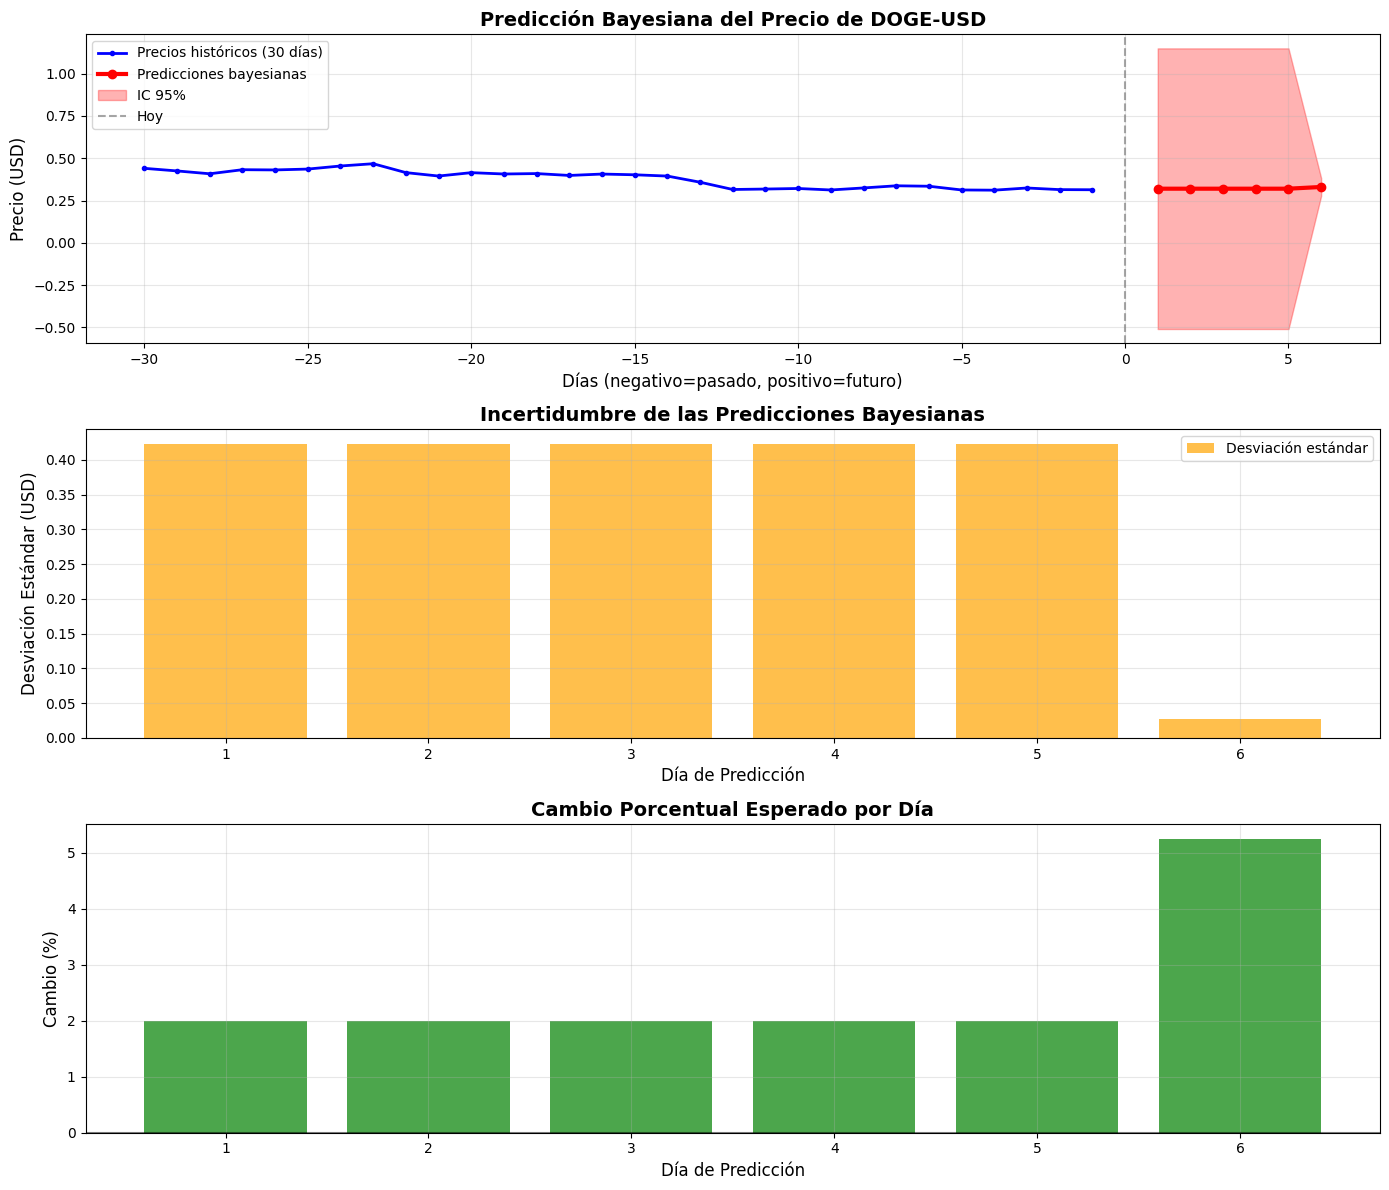

In [11]:
# 8. Visualización
print("\nCreando gráficos...")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Gráfico 1: Precios históricos y predicciones
days_hist = list(range(-len(prices), 0))
days_pred = list(range(1, 7))

# Convertir arrays a listas de floats para evitar errores de formato
prices_float = [float(p) for p in prices]
predictions_float = [float(p) if not isinstance(p, (list, np.ndarray)) else float(p[0]) for p in predictions]

ax1.plot(days_hist, prices_float, 'b-', linewidth=2, label='Precios históricos (30 días)', marker='o', markersize=3)
ax1.plot(days_pred, predictions_float, 'r-', linewidth=3, label='Predicciones bayesianas', marker='o', markersize=6)

# Intervalos de confianza - convertir a floats
pred_lower = [float(ci[0]) for ci in confidence_intervals]
pred_upper = [float(ci[1]) for ci in confidence_intervals]
ax1.fill_between(days_pred, pred_lower, pred_upper, alpha=0.3, color='red', label='IC 95%')

ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.7, label='Hoy')
ax1.set_title('Predicción Bayesiana del Precio de DOGE-USD', fontsize=14, fontweight='bold')
ax1.set_ylabel('Precio (USD)', fontsize=12)
ax1.set_xlabel('Días (negativo=pasado, positivo=futuro)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Incertidumbre de predicciones
std_predictions_float = [float(std) if not isinstance(std, (list, np.ndarray)) else float(std[0]) for std in std_predictions]
ax2.bar(range(1, 7), std_predictions_float, alpha=0.7, color='orange', label='Desviación estándar')
ax2.set_title('Incertidumbre de las Predicciones Bayesianas', fontsize=14, fontweight='bold')
ax2.set_ylabel('Desviación Estándar (USD)', fontsize=12)
ax2.set_xlabel('Día de Predicción', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Distribución de cambios predichos
changes_pct = [((float(pred) if not isinstance(pred, (list, np.ndarray)) else float(pred[0])) - float(prices[-1])) / float(prices[-1]) * 100
               for pred in predictions]
colors = ['green' if change > 0 else 'red' for change in changes_pct]
ax3.bar(range(1, 7), changes_pct, color=colors, alpha=0.7, label='Cambio esperado')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.set_title('Cambio Porcentual Esperado por Día', fontsize=14, fontweight='bold')
ax3.set_ylabel('Cambio (%)', fontsize=12)
ax3.set_xlabel('Día de Predicción', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# 9. Estadísticas del modelo
print(f"\nEstadísticas del Modelo:")
print(f"MAE (Error Absoluto Medio): ${train_mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): ${train_rmse:.4f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {train_mape:.2f}%")
print(f"Coeficientes del modelo: {len(bayes_model.coef_)}")
print(f"Alpha (precisión del ruido): {bayes_model.alpha_:.6f}")
print(f"Lambda (precisión coeficientes): {bayes_model.lambda_:.6f}")
print(f"Score de log-marginal: {bayes_model.scores_[-1]:.2f}")

# Interpretación del MAPE
if train_mape < 10:
    mape_interpretation = "Excelente precisión"
elif train_mape < 20:
    mape_interpretation = "Buena precisión"
elif train_mape < 50:
    mape_interpretation = "Precisión aceptable"
else:
    mape_interpretation = "Baja precisión"

print(f"Interpretación MAPE: {mape_interpretation}")

print(f"\nProbabilidad de aumento en los próximos 6 días:")
for i, (pred, std) in enumerate(zip(predictions, std_predictions)):
    # Convertir a escalares para evitar errores
    pred_val = float(pred) if not isinstance(pred, (list, np.ndarray)) else float(pred[0])
    std_val = float(std) if not isinstance(std, (list, np.ndarray)) else float(std[0])

    # Calcular probabilidad de que el precio sea mayor al actual
    prob_increase = 1 - stats.norm.cdf(float(prices[-1]), pred_val, std_val)
    print(f"Día {i+1}: {prob_increase:.1%}")

print("\n¡Análisis bayesiano completado!")
print("Nota: Las predicciones incluyen incertidumbre bayesiana y deben usarse con precaución.")
print(f"El modelo tiene un MAPE de {train_mape:.2f}%, lo que indica {mape_interpretation.lower()}.")


Estadísticas del Modelo:
MAE (Error Absoluto Medio): $0.0129
RMSE (Raíz del Error Cuadrático Medio): $0.0168
MAPE (Error Porcentual Absoluto Medio): 3.43%
Coeficientes del modelo: 8
Alpha (precisión del ruido): 2898.737677
Lambda (precisión coeficientes): 4048.854864
Score de log-marginal: 57.03
Interpretación MAPE: Excelente precisión

Probabilidad de aumento en los próximos 6 días:
Día 1: 50.6%
Día 2: 50.6%
Día 3: 50.6%
Día 4: 50.6%
Día 5: 50.6%
Día 6: 73.1%

¡Análisis bayesiano completado!
Nota: Las predicciones incluyen incertidumbre bayesiana y deben usarse con precaución.
El modelo tiene un MAPE de 3.43%, lo que indica excelente precisión.


In [13]:
# 9. Estadísticas del modelo
print(f"\nEstadísticas del Modelo:")
print(f"MAE (Error Absoluto Medio): ${train_mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): ${train_rmse:.4f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {train_mape:.2f}%")
print(f"Coeficientes del modelo: {len(bayes_model.coef_)}")
print(f"Alpha (precisión del ruido): {bayes_model.alpha_:.6f}")
print(f"Lambda (precisión coeficientes): {bayes_model.lambda_:.6f}")
print(f"Score de log-marginal: {bayes_model.scores_[-1]:.2f}")

# Interpretación del MAPE
if train_mape < 10:
    mape_interpretation = "Excelente precisión"
elif train_mape < 20:
    mape_interpretation = "Buena precisión"
elif train_mape < 50:
    mape_interpretation = "Precisión aceptable"
else:
    mape_interpretation = "Baja precisión"

print(f"Interpretación MAPE: {mape_interpretation}")

print(f"\nProbabilidad de aumento por fecha:")
print("-" * 50)
print(f"{'Fecha':<12} {'Prob. Aumento':<15} {'Confianza'}")
print("-" * 50)
for i, (pred, std, date) in enumerate(zip(predictions, std_predictions, future_dates)):
    # Convertir a escalares para evitar errores
    pred_val = float(pred) if not isinstance(pred, (list, np.ndarray)) else float(pred[0])
    std_val = float(std) if not isinstance(std, (list, np.ndarray)) else float(std[0])

    # Calcular probabilidad de que el precio sea mayor al actual
    prob_increase = 1 - stats.norm.cdf(float(prices[-1]), pred_val, std_val)

    # Clasificar confianza basada en probabilidad
    if prob_increase >= 0.7:
        confidence = "Alta"
    elif prob_increase >= 0.55:
        confidence = "Media"
    elif prob_increase >= 0.45:
        confidence = "Neutral"
    else:
        confidence = "Baja"

    print(f"{date.strftime('%Y-%m-%d'):<12} {prob_increase:<14.1%} {confidence}")

print("\n¡Análisis bayesiano completado!")
print("Nota: Las predicciones incluyen incertidumbre bayesiana y deben usarse con precaución.")
print(f"El modelo tiene un MAPE de {train_mape:.2f}%, lo que indica {mape_interpretation.lower()}.")

# Resumen ejecutivo con fechas
print(f"\n" + "="*70)
print("RESUMEN EJECUTIVO")
print("="*70)
print(f"Análisis realizado: {dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Datos analizados: {price_dates[0].strftime('%Y-%m-%d')} a {last_date.strftime('%Y-%m-%d')}")
print(f"Precio de referencia: ${float(prices[-1]):.4f} ({last_date.strftime('%Y-%m-%d')})")

# Asegurar que predictions_float existe para el resumen
if 'predictions_float' not in locals():
    predictions_float = [float(p) if not isinstance(p, (list, np.ndarray)) else float(p[0]) for p in predictions]

print(f"Predicción a 6 días: ${predictions_float[-1]:.4f} ({future_dates[-1].strftime('%Y-%m-%d')})")
print(f"Cambio esperado: {((predictions_float[-1] - float(prices[-1])) / float(prices[-1]) * 100):+.2f}%")
print(f"Precisión del modelo: {mape_interpretation} (MAPE: {train_mape:.2f}%)")

# Análisis de tendencia
upward_days = sum([1 for pred in predictions_float if pred > float(prices[-1])])
print(f"Días con tendencia alcista: {upward_days}/6 ({upward_days/6*100:.0f}%)")

# Mejor día para invertir según probabilidades
best_day_idx = 0
best_prob = 0
for i, (pred, std) in enumerate(zip(predictions, std_predictions)):
    pred_val = float(pred) if not isinstance(pred, (list, np.ndarray)) else float(pred[0])
    std_val = float(std) if not isinstance(std, (list, np.ndarray)) else float(std[0])
    prob = 1 - stats.norm.cdf(float(prices[-1]), pred_val, std_val)
    if prob > best_prob:
        best_prob = prob
        best_day_idx = i

print(f"Mejor oportunidad: {future_dates[best_day_idx].strftime('%Y-%m-%d')} (Prob: {best_prob:.1%})")


Estadísticas del Modelo:
MAE (Error Absoluto Medio): $0.0129
RMSE (Raíz del Error Cuadrático Medio): $0.0168
MAPE (Error Porcentual Absoluto Medio): 3.43%
Coeficientes del modelo: 8
Alpha (precisión del ruido): 2898.737677
Lambda (precisión coeficientes): 4048.854864
Score de log-marginal: 57.03
Interpretación MAPE: Excelente precisión

Probabilidad de aumento por fecha:
--------------------------------------------------
Fecha        Prob. Aumento   Confianza
--------------------------------------------------
2024-12-31   50.6%          Neutral
2025-01-01   50.6%          Neutral
2025-01-02   50.6%          Neutral
2025-01-03   50.6%          Neutral
2025-01-04   50.6%          Neutral
2025-01-05   73.1%          Alta

¡Análisis bayesiano completado!
Nota: Las predicciones incluyen incertidumbre bayesiana y deben usarse con precaución.
El modelo tiene un MAPE de 3.43%, lo que indica excelente precisión.

RESUMEN EJECUTIVO
Análisis realizado: 2025-08-28 19:53:13
Datos analizados: 2024-